In [0]:
import torchvision
import torch
import torch.optim as optim
import torch.nn as nn
import torchvision.transforms as transforms
import torch.nn.functional as F
import albumentations as A
import cv2
from torchsummary import summary
import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR
from albumentations import Compose, Normalize, HorizontalFlip, Cutout, Rotate, RandomCrop, PadIfNeeded
from albumentations.pytorch import ToTensor


In [0]:
import Model as Md
import Misclassified_image as MC
from TrainTestandUtils import TrainTestandUtils as Tt
import cyclic_lr as clr
from Albumentations import AlbumentationTransforms
from GradCAM import GradCAM
from LR_range_test import LR_test
from lr_finder import LRFinder
from Utils import *
import resnet_new as rn

In [0]:
#!pip install -U git+https://github.com/albu/albumentations --no-cache-dir

In [0]:

channel_means = (0.5, 0.5, 0.5)
channel_stdevs = (0.5, 0.5, 0.5)
train_transform = AlbumentationTransforms([                                      
                                      A.PadIfNeeded(min_height=36, min_width=36, border_mode = cv2.BORDER_REFLECT, always_apply=True,),
                                      A.RandomCrop(height=32, width=32, always_apply=True),
                                      A.HorizontalFlip(p = 0.7),
                                      A.Normalize(mean=channel_means, std=channel_stdevs),
                                      A.Cutout(num_holes=1, max_h_size=16,max_w_size = 16,p=0.7) 
                                       ])
test_transform = AlbumentationTransforms([A.Normalize(mean=channel_means, std=channel_stdevs)])


In [7]:

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                         download=True, transform=train_transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=512,
                                          shuffle=True, num_workers=8, pin_memory=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=test_transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=512,
                                         shuffle=False, num_workers=8)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [8]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print (device)

cuda


In [9]:

model = rn.Net().to(device)
summary(model, input_size=(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 32, 32]          73,728
         MaxPool2d-5          [-1, 128, 16, 16]               0
       BatchNorm2d-6          [-1, 128, 16, 16]             256
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,456
       BatchNorm2d-9          [-1, 128, 16, 16]             256
             ReLU-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]         147,456
      BatchNorm2d-12          [-1, 128, 16, 16]             256
             ReLU-13          [-1, 128, 16, 16]               0
           Conv2d-14          [-1, 256,

epoch = 1 Lr = 0.001  Loss=1.3494616746902466 Batch_id=97 Accuracy=38.08: 100%|██████████| 98/98 [00:23<00:00,  4.12it/s]
epoch = 2 Lr = 0.0029  Loss=1.3000202178955078 Batch_id=97 Accuracy=43.50: 100%|██████████| 98/98 [00:23<00:00,  4.13it/s]
epoch = 3 Lr = 0.0048  Loss=1.2899301052093506 Batch_id=97 Accuracy=41.79: 100%|██████████| 98/98 [00:23<00:00,  4.10it/s]
epoch = 4 Lr = 0.006699999999999999  Loss=1.2758851051330566 Batch_id=97 Accuracy=37.10: 100%|██████████| 98/98 [00:23<00:00,  4.15it/s]
epoch = 5 Lr = 0.0086  Loss=1.3332726955413818 Batch_id=97 Accuracy=34.15: 100%|██████████| 98/98 [00:23<00:00,  4.11it/s]
epoch = 6 Lr = 0.0105  Loss=1.602622628211975 Batch_id=97 Accuracy=23.13: 100%|██████████| 98/98 [00:23<00:00,  4.14it/s]
epoch = 7 Lr = 0.012400000000000001  Loss=1.6446171998977661 Batch_id=97 Accuracy=24.24: 100%|██████████| 98/98 [00:23<00:00,  4.12it/s]
epoch = 8 Lr = 0.014300000000000002  Loss=1.769487977027893 Batch_id=97 Accuracy=19.93: 100%|██████████| 98/98 [0

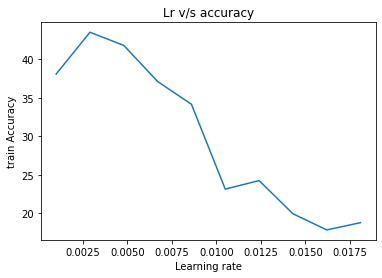

In [10]:
max_lr = 0.02
min_lr = 0.001
epoch = 10
criterion = nn.NLLLoss()
LR_test(max_lr, min_lr,device,epoch,model,criterion,trainloader,momemtum = 0.9,weight_decay=0.05, plot= True )

In [0]:

optimizer = optim.SGD(model.parameters(), lr=0.001,momentum=0.9,weight_decay=0.05 ) 
criterion = nn.NLLLoss()
scheduler = OneCycleLR(optimizer, max_lr = 0.014, total_steps=None, epochs=24, steps_per_epoch=len(trainloader), pct_start=0.167, anneal_strategy='linear', cycle_momentum=False, base_momentum=0.85, max_momentum=0.95, div_factor=10.0,final_div_factor =1)

In [0]:
new_model = Tt(model=model,
               device=device,
               optimizer=optimizer,
               criterion=criterion,
               scheduler=scheduler,
               trainloader=trainloader,
               testloader=testloader,
               epochs=24,
               input_size=(3,32,32),
               classes=classes)

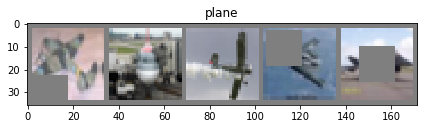

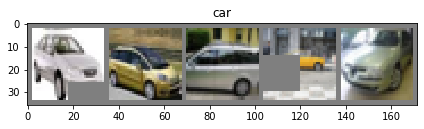

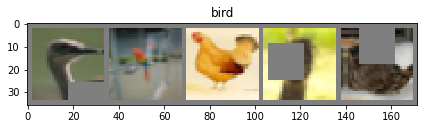

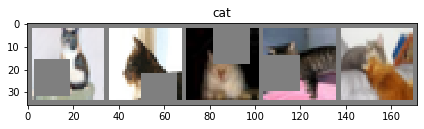

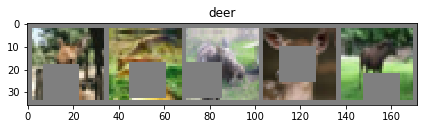

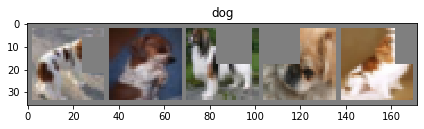

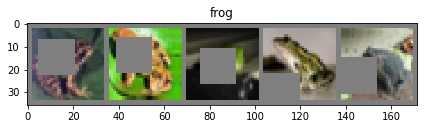

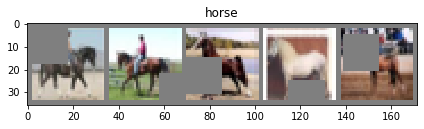

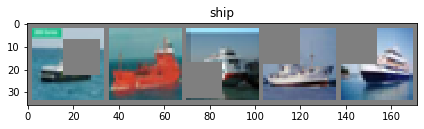

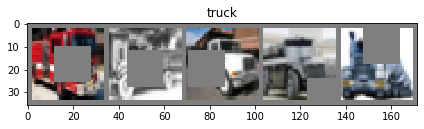

In [13]:
Tt.show_train_data(trainloader, classes)

In [14]:

LR = new_model.runModel()

  0%|          | 0/98 [00:00<?, ?it/s]

EPOCH  1


Loss=1.3670824766159058 Batch_id=97 Accuracy=39.50: 100%|██████████| 98/98 [00:23<00:00,  4.13it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.0027, Accuracy: 5300/10000 (53.00%)

EPOCH  2


Loss=1.120457410812378 Batch_id=97 Accuracy=55.45: 100%|██████████| 98/98 [00:23<00:00,  4.09it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.0022, Accuracy: 6182/10000 (61.82%)

EPOCH  3


Loss=1.0395891666412354 Batch_id=97 Accuracy=62.16: 100%|██████████| 98/98 [00:23<00:00,  4.11it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.0019, Accuracy: 6568/10000 (65.68%)

EPOCH  4


Loss=0.9220380187034607 Batch_id=97 Accuracy=66.14: 100%|██████████| 98/98 [00:23<00:00,  4.09it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.0018, Accuracy: 6813/10000 (68.13%)

EPOCH  5


Loss=0.8833493590354919 Batch_id=97 Accuracy=69.54: 100%|██████████| 98/98 [00:23<00:00,  4.09it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.0016, Accuracy: 7196/10000 (71.96%)

EPOCH  6


Loss=0.7739871740341187 Batch_id=97 Accuracy=72.32: 100%|██████████| 98/98 [00:23<00:00,  4.13it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.0014, Accuracy: 7493/10000 (74.93%)

EPOCH  7


Loss=0.7519703507423401 Batch_id=97 Accuracy=74.44: 100%|██████████| 98/98 [00:23<00:00,  4.12it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.0013, Accuracy: 7705/10000 (77.05%)

EPOCH  8


Loss=0.7584412097930908 Batch_id=97 Accuracy=76.15: 100%|██████████| 98/98 [00:23<00:00,  4.10it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.0013, Accuracy: 7747/10000 (77.47%)

EPOCH  9


Loss=0.6511687636375427 Batch_id=97 Accuracy=77.26: 100%|██████████| 98/98 [00:23<00:00,  4.14it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.0013, Accuracy: 7841/10000 (78.41%)

EPOCH  10


Loss=0.556780993938446 Batch_id=97 Accuracy=78.99: 100%|██████████| 98/98 [00:23<00:00,  4.13it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.0012, Accuracy: 7983/10000 (79.83%)

EPOCH  11


Loss=0.644646406173706 Batch_id=97 Accuracy=80.07: 100%|██████████| 98/98 [00:24<00:00,  4.08it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.0011, Accuracy: 8149/10000 (81.49%)

EPOCH  12


Loss=0.5135345458984375 Batch_id=97 Accuracy=81.06: 100%|██████████| 98/98 [00:23<00:00,  4.14it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.0011, Accuracy: 8118/10000 (81.18%)

EPOCH  13


Loss=0.5831485390663147 Batch_id=97 Accuracy=81.34: 100%|██████████| 98/98 [00:23<00:00,  4.13it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.0011, Accuracy: 8170/10000 (81.70%)

EPOCH  14


Loss=0.5944710373878479 Batch_id=97 Accuracy=82.45: 100%|██████████| 98/98 [00:23<00:00,  4.10it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.0011, Accuracy: 8117/10000 (81.17%)

EPOCH  15


Loss=0.5163113474845886 Batch_id=97 Accuracy=83.08: 100%|██████████| 98/98 [00:23<00:00,  4.10it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.0009, Accuracy: 8431/10000 (84.31%)

EPOCH  16


Loss=0.5789437294006348 Batch_id=97 Accuracy=83.88: 100%|██████████| 98/98 [00:23<00:00,  4.14it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.0009, Accuracy: 8471/10000 (84.71%)

EPOCH  17


Loss=0.5476971864700317 Batch_id=97 Accuracy=84.47: 100%|██████████| 98/98 [00:23<00:00,  4.13it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.0010, Accuracy: 8316/10000 (83.16%)

EPOCH  18


Loss=0.4379744827747345 Batch_id=97 Accuracy=84.93: 100%|██████████| 98/98 [00:23<00:00,  4.16it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.0011, Accuracy: 8111/10000 (81.11%)

EPOCH  19


Loss=0.44991356134414673 Batch_id=97 Accuracy=85.31: 100%|██████████| 98/98 [00:23<00:00,  4.11it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.0010, Accuracy: 8378/10000 (83.78%)

EPOCH  20


Loss=0.4238940179347992 Batch_id=97 Accuracy=85.83: 100%|██████████| 98/98 [00:23<00:00,  4.12it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.0011, Accuracy: 8213/10000 (82.13%)

EPOCH  21


Loss=0.4510328769683838 Batch_id=97 Accuracy=86.38: 100%|██████████| 98/98 [00:23<00:00,  4.10it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.0008, Accuracy: 8589/10000 (85.89%)

EPOCH  22


Loss=0.42102500796318054 Batch_id=97 Accuracy=86.76: 100%|██████████| 98/98 [00:23<00:00,  4.14it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.0010, Accuracy: 8334/10000 (83.34%)

EPOCH  23


Loss=0.39054930210113525 Batch_id=97 Accuracy=86.96: 100%|██████████| 98/98 [00:23<00:00,  4.12it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.0009, Accuracy: 8486/10000 (84.86%)

EPOCH  24


Loss=0.4815140664577484 Batch_id=97 Accuracy=87.37: 100%|██████████| 98/98 [00:23<00:00,  4.14it/s]


Test set: Average loss: 0.0010, Accuracy: 8403/10000 (84.03%)



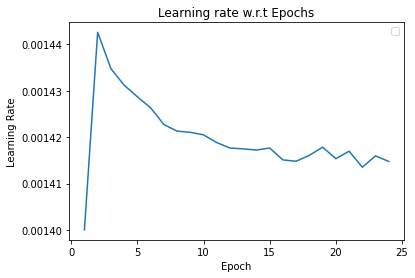

In [15]:
import numpy as np
curves = [{"x":np.arange(1,25), "y": LR, "label": "","xlabel": "Epoch", "ylabel":"Learning Rate"}]
Tt.plot_curve(curves,"Learning rate w.r.t Epochs",Figsize = (6,4))

In [16]:
new_model.total_accuracy()

Accuracy of the network on the 10000 test images: 84 %


In [0]:
#MC.gradcam_misclassified(new_model.misclassified_images,model,device)

In [18]:
new_model.classwise_acc()


Accuracy of plane : 100 %
Accuracy of   car : 100 %
Accuracy of  bird : 100 %
Accuracy of   cat : 41 %
Accuracy of  deer : 85 %
Accuracy of   dog : 66 %
Accuracy of  frog : 90 %
Accuracy of horse : 83 %
Accuracy of  ship : 91 %
Accuracy of truck : 100 %



Length of train acc is 24
Length of test acc is 24


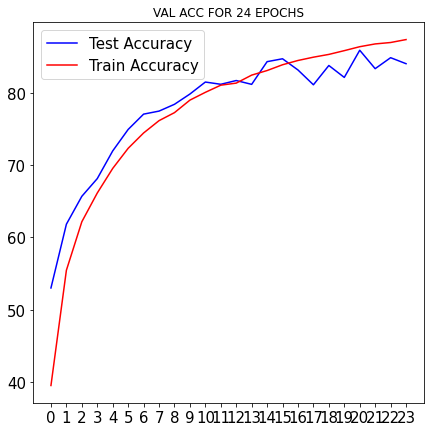

In [19]:
new_model.plot_train_test_acc()